In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import cv2
import gc
from tqdm import tqdm
%matplotlib inline

import glob
import os

##
%matplotlib inline 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2 
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy,categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet121
from keras.applications.nasnet import NASNetMobile
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from keras_tqdm import TQDMNotebookCallback
from keras.layers import Dense, Dropout, Flatten, Activation,GlobalAveragePooling2D
from keras.models import Sequential,Model
start = dt.datetime.now()
import ast
from tqdm import tqdm, tqdm_notebook

Using TensorFlow backend.


In [2]:
## No of classes

In [3]:
print(len(os.listdir('./data/train_simplified')))
print(len(os.listdir('./data/train_raw')))

340
340


In [4]:
use_raw = False
if use_raw ==True:
    csv_files = r'D:\Project data\quickdraw-doodle-recognition\quickdraw_data\My code\data\train_raw'
else:
    csv_files = r'D:\Project data\quickdraw-doodle-recognition\quickdraw_data\My code\data\train_simplified'
split_data = r'D:\Project data\quickdraw-doodle-recognition\quickdraw_data\My code\data\30K'

In [5]:
### I dont have the too much of GPU to process such large dataset 

In [6]:
nrows = 30000
files = os.listdir(csv_files)

In [7]:
##(old Code) I intensionally commented the for loop since I dont want to execute it again

for file in tqdm(files, total=340):
    source_file_path = os.path.join(csv, file)
    df = pd.read_csv(source_file_path, usecols = ['countrycode', 'drawing', 'key_id', 'recognized'],
                     nrows = nrows)
    df1 = df.head(int(nrows/2))
    df1_train = df1.head(int(nrows/2/100*90))
    df1_valid = df1.tail(int(nrows/2/100*10))
    
    df2 = df.tail(int(nrows/2))
    df2_train = df2.head(int(nrows/2/100*90))
    df2_valid = df2.tail(int(nrows/2/100*10))
    
    path = os.path.join(split_data,'data_1', 'train')
    os.makedirs(path, exist_ok = True)
    df1_train.to_csv(os.path.join(path, file), index= False)
    path = os.path.join(split_data,'data_1', 'valid')
    os.makedirs(path, exist_ok = True)    
    df1_valid.to_csv(os.path.join(path, file), index= False)
    
    
    path = os.path.join(split_data,'data_2', 'train')
    os.makedirs(path, exist_ok = True)
    df2_train.to_csv(os.path.join(path, file), index= False)
    path = os.path.join(split_data,'data_2', 'valid')
    os.makedirs(path, exist_ok = True)   
    df2_valid.to_csv(os.path.join(path, file), index= False)
    

##Creating a subset of data with 30K datapoints in each class

#####Commented the writing to csv files below since I dont want to execute it again and again
for file in tqdm(files, total=340):
    source_file_path = os.path.join(csv_files, file)
    df = pd.read_csv(source_file_path, usecols = ['countrycode', 'drawing', 'key_id', 'recognized'],
                     nrows = nrows)
    df1 = df.head(int(nrows/2))
    df1_train = df1.head(int(nrows/2/100*90))
    df1_valid = df1.tail(int(nrows/2/100*10))
    
    df2 = df.tail(int(nrows/2))
    df2_train = df2.head(int(nrows/2/100*90))
    df2_valid = df2.tail(int(nrows/2/100*10))
    
    df_train = pd.concat([df1_train, df2_train])
    df_valid = pd.concat([df1_valid, df2_valid])
    
    path = os.path.join(split_data, 'train')
    os.makedirs(path, exist_ok = True)
    #df_train.to_csv(os.path.join(path, file), index= False)
    path = os.path.join(split_data,'valid')
    os.makedirs(path, exist_ok = True)    
    #df_valid.to_csv(os.path.join(path, file), index= False)
    

##### Looking at the data

In [10]:
INPUT_PATH = './data/30K'

# Exploring train csv files 

df_train = pd.read_csv('./data/train_simplified/airplane.csv', index_col = 'key_id', nrows = 5)
df_train.head(5)

,countrycode,drawing,recognized,timestamp,word
key_id,,,,,
5152802093400064,US,"[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...",True,2017-03-08 21:12:07.266040,airplane
6622904974311424,CA,"[[[2, 14, 34, 126], [57, 45, 38, 47]], [[41, 4...",False,2017-03-06 21:39:04.690130,airplane
6577010312740864,US,"[[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...",True,2017-03-23 02:08:35.229980,airplane
5643224746033152,US,"[[[82, 49, 15, 4, 0, 5, 30, 85, 89, 93, 112, 1...",True,2017-03-10 00:35:17.531970,airplane
6670046841536512,IL,"[[[64, 38, 23, 8, 0, 6, 26, 68], [74, 77, 84, ...",True,2017-01-23 18:11:11.658170,airplane


In [123]:
words = df_train['word'].tolist()
drawings = [ast.literal_eval(pts) for pts in df_train[0:5]['drawing'].values]
len(drawings)

5

Text(0.5, 0.98, '')

Text(0.5, 1.0, 'airplane')

Text(0.5, 1.0, 'airplane')

Text(0.5, 1.0, 'airplane')

Text(0.5, 1.0, 'airplane')

Text(0.5, 1.0, 'airplane')

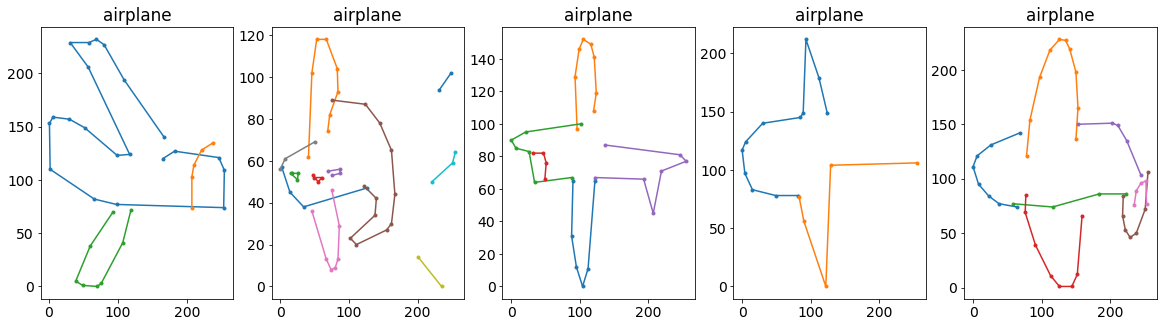

In [136]:
fig, ax =plt.subplots(1,5,figsize=(20,5))
fig.suptitle('')
for i, drawing in enumerate(drawings):
    for x,y in drawing:
        ax[i].plot(x,y, marker='.')


    ax[i].set_title(words[i])

Text(0.5, 1.0, 'airplane')

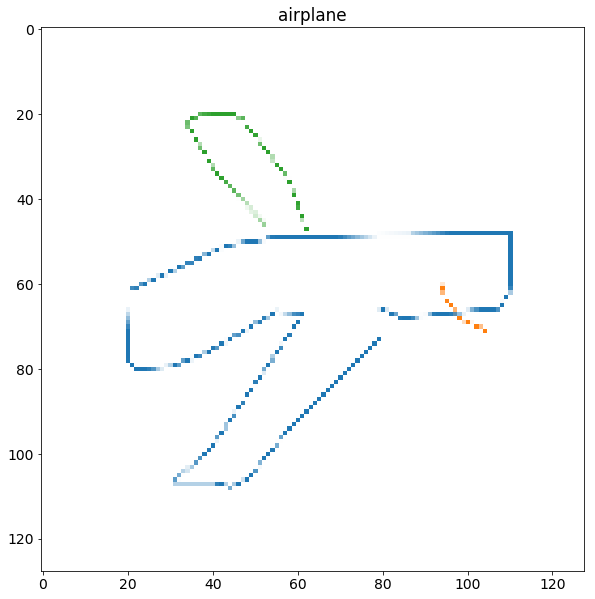

In [142]:
i = 0

def draw2img(drawing, Xsize=256, Ysize=256, lw = 4):
    '''
    converts drawing to image
    '''
    fig, ax = plt.subplots()
    for x,y in drawing:
        ax.plot(x, y ,linewidth=lw) #  marker='.', See which line width is better, <4 might be good
    ax.axis('off')
    fig.canvas.draw()    
    X = np.array(fig.canvas.renderer._renderer)
    plt.close(fig)
    # image resizing. Original X is of various size due to strokes variable's length
    return (cv2.resize(X, (Xsize,Ysize)) / 255.)[::-1]

image = draw2img(drawings[i], 128, 128)
plt.imshow(image)
plt.title(words[i])


In [9]:
##files = glob.glob(r'D:\Project data\quickdraw-doodle-recognition\quickdraw_data\My code\data\30K\data_1\train\*.csv')
##len(files)

In [9]:

DP_DIR = r'./data/30K_zip'
INPUT_DIR = './data/'


##INPUT_DIR = r'D:\Project data\quickdraw-doodle-recognition\quickdraw_data\My code\data\30K'

BASE_SIZE = 256
SIZE = 64
NCSVS = 100
NCATS = 340

np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

#def list_all_categories():
#    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
#    return ([f2cat(f) for f in files])

class Simplified():
    def __init__(self, input_path = './data', file_dir = 'train_simplified'):
        self.input_path = input_path
        self.file_dir = file_dir
    
    def list_all_categoris(self):
        files = os.listdir(os.path.join(self.input_path, self.file_dir))
        return ([f2cat(f) for f in files])
    
    def read_training_csv(self, category, nrows= None, ncols = None, drawing_transform = False):
        
        df = pd.read_csv(os.path.join(self.input_path, self.file_dir,category+ '.csv' ), 
                         nrows= nrows,usecols = ncols)
        if drawing_transform:
            df['drawing'] = df['drawing'].apply(json.loads)
        
        return df


In [10]:
use_raw = False
if use_raw ==True:
    file_DIR = 'train_raw'
else:
    file_DIR = 'train_simplified'

s = Simplified('./data', file_DIR)
NCSVS = 100
categories = s.list_all_categoris()
print(len(categories))

340


In [23]:
path = r'D:\Project data\quickdraw-doodle-recognition\quickdraw_data\My code\data'
path = os.path.join(path ,row_count) 
path_new = path + '_zip'

In [27]:
## Value to update based on GPU Memory
nrows =5000
row_count ='5K'

##path = r'D:\Project data\quickdraw-doodle-recognition\quickdraw_data\My code\data\30K'
path = r'D:\Project data\quickdraw-doodle-recognition\quickdraw_data\My code\data' 
path = os.path.join(path ,row_count) 

os.makedirs(path, exist_ok = True)

for y, category in tqdm_notebook(enumerate(categories), total= len(categories)):
    df = s.read_training_csv(category, nrows= nrows)
    df['y'] = y
    df['cv'] = (df.key_id // 10 ** 7) % NCSVS
    for k in range(NCSVS):
        filename = 'train_k{}.csv'.format(k)
        chunk = df[df['cv']== k]
        chunk = chunk.drop(['cv'], axis =1)
        if y == 0:
            chunk.to_csv(os.path.join(path,filename), index = False)
        else:
            chunk.to_csv(os.path.join(path,filename),mode = 'a', header = False, index = False)

In [28]:
from sklearn.utils import shuffle
##path = r'D:\Project data\quickdraw-doodle-recognition\quickdraw_data\My code\data\30K'
path_new = path + '_zip'
##path_new = r'D:\Project data\quickdraw-doodle-recognition\quickdraw_data\My code\data\30K_zip'
os.makedirs(path_new, exist_ok = True)

for k in tqdm_notebook(range(NCSVS),total=NCSVS):
    filename = 'train_k{}.csv'.format(k)
    df = pd.read_csv(os.path.join(path,filename))
    df = shuffle(df)
    ##Uncomment to populate .gz file
    df.to_csv(os.path.join(path_new,filename + '.gz'), compression='gzip',index = False)

In [12]:


def apk(actual, predicted, k=3):
    """

    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):

        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

In [13]:
apk(actual= [1,2,3], predicted = [2,1,3])

1.0

In [14]:
def mapk(actual, predicted, k=3):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual,predicted)])

In [15]:
def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [16]:
STEPS = 800
EPOCHS = 16
size = 64
batchsize = 680

#### Baseline

In [14]:
model = MobileNet(input_shape = (size, size,1), alpha = 1.0, weights = None, classes = NCATS)

model.compile(optimizer = Adam(lr = .002), loss = 'categorical_crossentropy' , 
              metrics = [ categorical_crossentropy,categorical_accuracy,top_3_accuracy])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
__________

Training with Image Generator

In [17]:
## Drawing Grey Scale Images
def draw_cv2(raw_strokes, size = 64, lw =6 , time_color = True):
    img = np.zeros((BASE_SIZE,BASE_SIZE), np.uint8)
    for t,stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            if time_color:
                color = 255 - min(10,t)*13
            else:
                color = 255
            _ = cv2.line(img, (stroke[0][i],stroke[1][i]),
                        (stroke[0][i+1],stroke[1][i+1]),color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size,size))
    else:
        return img


## Drawing RGB Images
## def draw_cv2_color later on 

def draw_cv2_color(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE,3), np.uint8)
    for t, stroke in enumerate(raw_strokes):     
        inertia_x = 0
        inertia_y = 0
        for i in range(len(stroke[0]) - 1):
            #color = 255 - min(t, 10) * 13 if time_color else 255 ##
            color = int(255 - 245*(float(t)/len(raw_strokes))) if time_color else 255 ## 
            ####print(color)
            sx = stroke[0][i]
            sy = stroke[1][i]
            ex = stroke[0][i + 1]
            ey = stroke[1][i + 1]
            color_v =  (np.sqrt((sx-ex)*(sx-ex) + (sy-ey)*(sy-ey)) / np.sqrt(size*size)) * 255 ## (1~0)
            color_a = (np.sqrt((inertia_x-ex)*(inertia_x-ex) + (inertia_y-ey)*(inertia_y-ey)) / np.sqrt(size*size*4)) * 255 ## 가속력 (1~0)
            _ = cv2.line(img, (sx, sy), (ex, ey), (color,color_v,color_a), lw)
            inertia_x = 2*ex -sx
            inertia_y = 2*ey-sy
            
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

    
##color new func
def draw_cv2_color_new(raw_strokes, size=256, lw=6, time_color=True, last_drop_r = 0.0):
    if use_raw ==False:
        return draw_cv2_color(raw_strokes, size=size, lw=lw, time_color=time_color)
    stx_min, sty_min = 99999, 99999
    stx_max, sty_max = 0,0
    #stt_se = 0  
    ett=0  
    
    for t, stroke in enumerate(raw_strokes):
        if t == len(raw_strokes) -1:
            #print(stroke)
            ett = int(stroke[2][-1])
        for i in range(len(stroke[0])):
            stx_min = min(stx_min, int(stroke[0][i]))
            stx_max = max(stx_max, int(stroke[0][i]))
            sty_min = min(sty_min, int(stroke[1][i]))
            sty_max = max(sty_max, int(stroke[1][i]))
    
    limit_ett = 20*1000   
    ofs = 15
    
    if int(sty_max-sty_min+2*ofs) > 6000 or int(stx_max-stx_min+2*ofs)  > 6000:
        img = np.zeros((6000,6000,3), np.uint8)
    else:
        img = np.zeros((int(sty_max-sty_min+2*ofs), int(stx_max-stx_min+2*ofs),3), np.uint8)

        
    for t, stroke in enumerate(raw_strokes):     
        inertia_x = 0
        inertia_y = 0
        pre_st_t = 0 
        for i in range(len(stroke[0]) - 1):
            #color = 255 - min(t, 10) * 13 if time_color else 255 ## 순서
            color = int(255 - 245*float(t)/len(raw_strokes)) if time_color else 255 ## 순서 개선
            sx = int(stroke[0][i]) - stx_min +ofs
            sy = int(stroke[1][i]) - sty_min +ofs
            st = stroke[2][i]
            ex = int(stroke[0][i + 1])- stx_min +ofs
            ey = int(stroke[1][i + 1])- sty_min +ofs
            et = stroke[2][i+1]
            
            
            time = et-st
            if time ==0:
                time = 1
            
            color_v =  min(int((np.sqrt((sx-ex)*(sx-ex) + (sy-ey)*(sy-ey)) / time)*255.0), 255) ## 속력
            color_a = min(int((np.sqrt((inertia_x-ex)*(inertia_x-ex) + (inertia_y-ey)*(inertia_y-ey)) / np.sqrt(time*time))*255.0), 255) ## 가속력 (1~0)
            _ = cv2.line(img, (sx, sy), (ex, ey), (color,color_v,color_a), lw)
            
            if i==0:
                color_inter = int((float(et-pre_st_t)/limit_ett)*245)+10
                _ = cv2.circle(img, (sx, sy), lw, (0,0,color_inter), -1) ##interval time
            
            if i==len(stroke[0])-2 and t == len(raw_strokes) -1:
                color_end = int((float(ett)/(limit_ett)*245))+10

                _ = cv2.circle(img, (sx, sy), lw, (0,color_end,0), -1) ##end time
                
            inertia_x = 2*ex -sx
            inertia_y = 2*ey-sy
            pre_st_t=et
            
    return cv2.resize(img, (size, size)) 


In [18]:
## path_new has the path of the zip folder populated

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    
    while True:
        for k in np.random.permutation(ks):
            ##filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            filename = os.path.join(path_new, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize = batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                x = np.zeros((len(df), SIZE, SIZE, 1))
                for i, raw_strokes in enumerate(df['drawing'].values):
                    x[i,:,:,0] = draw_cv2(raw_strokes, size=size, lw=lw,time_color=time_color)
                x= preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df['y'], num_classes = NCATS)
                yield x,y    
                
###to check memory size                
def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [24]:
###nrows = 30000
## path_new has the path of the zip folder populated

#valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=nrows)
valid_df = pd.read_csv(os.path.join(path_new, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=nrows)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))



(5000, 64, 64, 1) (5000, 340)
Validation array memory 0.08 GB


In [25]:
## Here range(NCSVS - 1) is used so that traink_99 is not used for training
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

In [26]:
x, y = next(train_datagen)

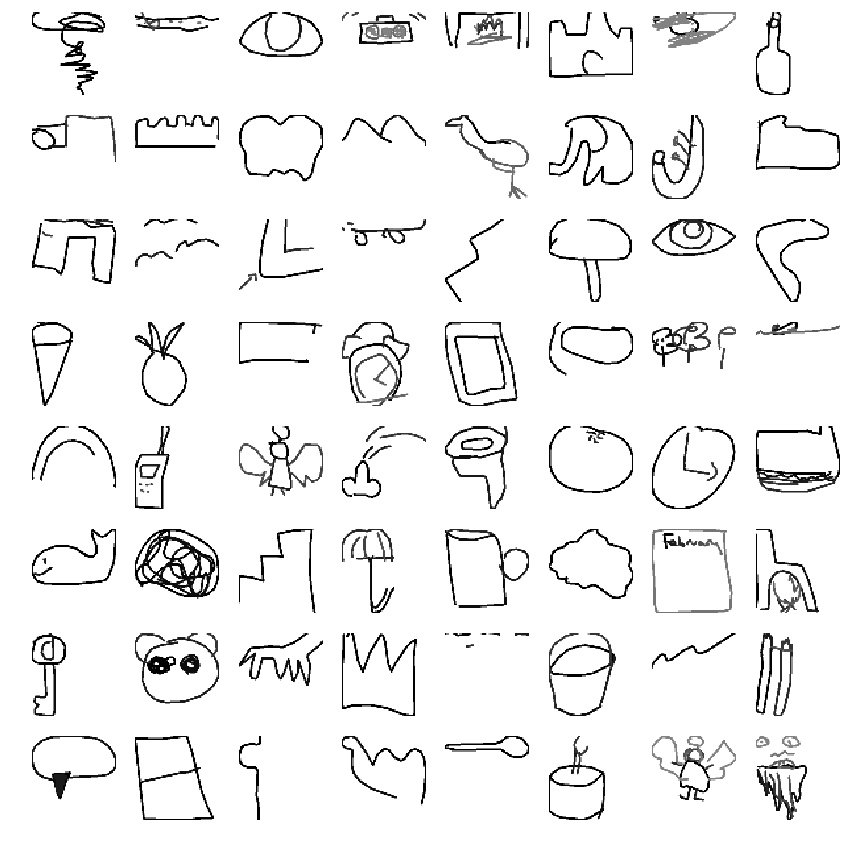

In [39]:

n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [27]:
hists = []

In [28]:
callbacks = [ ReduceLROnPlateau(monitor = 'val_top_3_accuracy', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
              ModelCheckpoint('model.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                    save_weights_only=True),
              EarlyStopping(monitor='val_loss',
                           patience=3,
                           verbose=1,
                           min_delta=0.00001,
                           mode='min'),
              TQDMNotebookCallback()]


hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=70, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

NameError: name 'model' is not defined

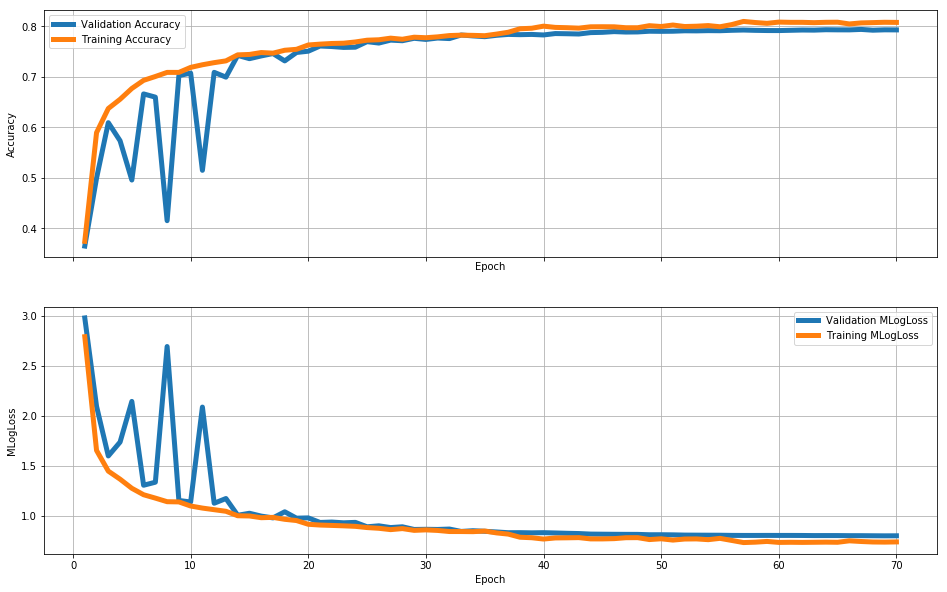

In [29]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [44]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

30000/30000 [==============================] - ETA: 59 - ETA: 45 - ETA: 43 - ETA: 38 - ETA: 34 - ETA: 26 - ETA: 22 - ETA: 19 - ETA: 17 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 

In [45]:
test_path = 'D:\Project data\quickdraw-doodle-recognition\quickdraw_data\My code\data'
test = pd.read_csv(os.path.join(test_path, 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


(112199, 3) (112199, 64, 64, 1)
Test array memory 1.71 GB


In [46]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = s.list_all_categoris()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

112199/112199 [==============================] - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 57s - ETA: 53 - ETA: 51 - ETA: 49 - ETA: 47 - ETA: 45 - ETA: 43 - ETA: 42 - ETA: 41 - ETA: 40 - ETA: 39 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - 

,a,b,c
0,234,281,266
1,144,36,226
2,305,62,53
3,187,303,304
4,113,56,112


(112199, 3)

,a,b,c
0,radio,stereo,snorkel
1,hockey_puck,bottlecap,pool
2,The_Great_Wall_of_China,castle,camel
3,mountain,tent,The_Eiffel_Tower
4,fireplace,campfire,fire_hydrant


(112199, 3)

In [48]:
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('submission_mobilenet.csv', index=False)
submission.head()
submission.shape

,key_id,word
0,9000003627287624,radio stereo snorkel
1,9000010688666847,hockey_puck bottlecap pool
2,9000023642890129,The_Great_Wall_of_China castle camel
3,9000038588854897,mountain tent The_Eiffel_Tower
4,9000052667981386,fireplace campfire fire_hydrant


(112199, 2)

#### Build models with different backbones

In [37]:
ONE_EPOCH_IMAGES    = 1700000
nbbone =5
backbone_models_str =  ['MobileNet', 'ResNet50', 'Xception', 'DenseNet121', 'NASNetMobile', 'InceptionResNetV2']
backbone_models     =  [MobileNet, ResNet50, Xception, DenseNet121, NASNetMobile, InceptionResNetV2]
max_batch           =  [256,128,128,128,256,90]
batchsize           =  max_batch[nbbone]
last_freeze_lnum    =  None
STEPS               =  ONE_EPOCH_IMAGES // batchsize
EPOCHS              =  16
size                =  139
input_shape         =  (size,size,3)
last_drop           = 0.3
valid_file_num      = 99
is_restart          = True
####

model_name = backbone_models_str[5] + '_is_' + str(input_shape) + '_bs_' + str(batchsize) + '_lf_' + str(last_freeze_lnum)
model_name = model_name + '_vf_' +str(valid_file_num) + '_use_raw_' + str(use_raw)
weight_name = model_name + '.h5'

os.makedirs('./weights', exist_ok = True)

best_save_model_file = 'weights/'+ weight_name
is_restart = True

print(best_save_model_file)

## callbacks
callbacks = [ ReduceLROnPlateau(monitor = 'val_loss', factor=0.5, patience=2, min_delta=0.00001,
                          mode='min', min_lr=1e-5, verbose=1),
              ModelCheckpoint(filepath=best_save_model_file, monitor='val_loss', mode='min', save_best_only=True,
                    save_weights_only=True),
              EarlyStopping(monitor='val_loss',
                           patience=3,
                           verbose=1,
                           min_delta=0.00001,
                           mode='min'),
              TQDMNotebookCallback()]


weights/InceptionResNetV2_is_(139, 139, 3)_bs_90_lf_None_vf_99_use_raw_False.h5


In [30]:
def build_model(backbone = MobileNet, input_shape = input_shape, use_imagenet = 'imagenet',
                base_freeze = False,last_freeze_lnum= None,last_drop=None ):
    if input_shape[2] == 1:
        use_imagenet = None
    else:
        use_imagenet = use_imagenet
    if backbone == MobileNet:
        alpha = 1.0
        base_model = backbone(input_shape = input_shape, alpha = 1.0, weights = use_imagenet, include_top = False)
    else:
        base_model = backbone(input_shape = input_shape, weights = use_imagenet, include_top = False)
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation = 'relu')(x)
    if last_drop!= 0:
        x = Dropout(last_drop)(x)
    predictions = Dense(NCATS, activation = 'softmax', name='lastfc')(x)
    
    model = Model(inputs= base_model.input, outputs = predictions)
    
    if base_freeze == True:
        for layer in base_model.layers:
            layer.trainable = False
            
    if last_freeze_lnum is not None:
        for i in range(len(model.layers)- last_freeze_lnum):
            model.layer[i].trainable = False
    
    #model.compile(optimizer = Adam(lr = .002),loss = 'categorical_crossentropy',
    #              metrics = [categorical_crossentropy,categorical_accuracy,top_3_accuracy])
    
    model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
                  metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy]) 
        
    return model    

In [31]:
model = build_model(backbone = backbone_models[nbbone], input_shape = input_shape, use_imagenet = 'imagenet', 
                base_freeze = False,last_freeze_lnum= last_freeze_lnum,last_drop =last_drop)

In [83]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 139, 139, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1016 (Conv2D)            (None, 69, 69, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1016 (Batch (None, 69, 69, 32)   96          conv2d_1016[0][0]                
__________________________________________________________________________________________________
activation_1016 (Activation)    (None, 69, 69, 32)   0           batch_normalization_1016[0][0]   
__________________________________________________________________________________________________
conv2d_101

__________________________________________________________________________________________________
mixed_5b (Concatenate)          (None, 15, 15, 320)  0           activation_1021[0][0]            
                                                                 activation_1023[0][0]            
                                                                 activation_1026[0][0]            
                                                                 activation_1027[0][0]            
__________________________________________________________________________________________________
conv2d_1031 (Conv2D)            (None, 15, 15, 32)   10240       mixed_5b[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1031 (Batch (None, 15, 15, 32)   96          conv2d_1031[0][0]                
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_1034 (Activation)    (None, 15, 15, 32)   0           batch_normalization_1034[0][0]   
__________________________________________________________________________________________________
activation_1036 (Activation)    (None, 15, 15, 32)   0           batch_normalization_1036[0][0]   
__________________________________________________________________________________________________
activation_1039 (Activation)    (None, 15, 15, 64)   0           batch_normalization_1039[0][0]   
__________________________________________________________________________________________________
block35_2_mixed (Concatenate)   (None, 15, 15, 128)  0           activation_1034[0][0]            
                                                                 activation_1036[0][0]            
                                                                 activation_1039[0][0]            
__________

__________________________________________________________________________________________________
conv2d_1046 (Conv2D)            (None, 15, 15, 32)   10240       block35_3_ac[0][0]               
__________________________________________________________________________________________________
conv2d_1048 (Conv2D)            (None, 15, 15, 32)   9216        activation_1047[0][0]            
__________________________________________________________________________________________________
conv2d_1051 (Conv2D)            (None, 15, 15, 64)   27648       activation_1050[0][0]            
__________________________________________________________________________________________________
batch_normalization_1046 (Batch (None, 15, 15, 32)   96          conv2d_1046[0][0]                
__________________________________________________________________________________________________
batch_normalization_1048 (Batch (None, 15, 15, 32)   96          conv2d_1048[0][0]                
__________

__________________________________________________________________________________________________
conv2d_1059 (Conv2D)            (None, 15, 15, 32)   10240       block35_5_ac[0][0]               
__________________________________________________________________________________________________
conv2d_1062 (Conv2D)            (None, 15, 15, 48)   13824       activation_1061[0][0]            
__________________________________________________________________________________________________
batch_normalization_1059 (Batch (None, 15, 15, 32)   96          conv2d_1059[0][0]                
__________________________________________________________________________________________________
batch_normalization_1062 (Batch (None, 15, 15, 48)   144         conv2d_1062[0][0]                
__________________________________________________________________________________________________
activation_1059 (Activation)    (None, 15, 15, 32)   0           batch_normalization_1059[0][0]   
__________

block35_7_conv (Conv2D)         (None, 15, 15, 320)  41280       block35_7_mixed[0][0]            
__________________________________________________________________________________________________
block35_7 (Lambda)              (None, 15, 15, 320)  0           block35_6_ac[0][0]               
                                                                 block35_7_conv[0][0]             
__________________________________________________________________________________________________
block35_7_ac (Activation)       (None, 15, 15, 320)  0           block35_7[0][0]                  
__________________________________________________________________________________________________
conv2d_1073 (Conv2D)            (None, 15, 15, 32)   10240       block35_7_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_1073 (Batch (None, 15, 15, 32)   96          conv2d_1073[0][0]                
__________

batch_normalization_1081 (Batch (None, 15, 15, 64)   192         conv2d_1081[0][0]                
__________________________________________________________________________________________________
activation_1076 (Activation)    (None, 15, 15, 32)   0           batch_normalization_1076[0][0]   
__________________________________________________________________________________________________
activation_1078 (Activation)    (None, 15, 15, 32)   0           batch_normalization_1078[0][0]   
__________________________________________________________________________________________________
activation_1081 (Activation)    (None, 15, 15, 64)   0           batch_normalization_1081[0][0]   
__________________________________________________________________________________________________
block35_9_mixed (Concatenate)   (None, 15, 15, 128)  0           activation_1076[0][0]            
                                                                 activation_1078[0][0]            
          

batch_normalization_1088 (Batch (None, 7, 7, 384)    1152        conv2d_1088[0][0]                
__________________________________________________________________________________________________
batch_normalization_1091 (Batch (None, 7, 7, 384)    1152        conv2d_1091[0][0]                
__________________________________________________________________________________________________
activation_1088 (Activation)    (None, 7, 7, 384)    0           batch_normalization_1088[0][0]   
__________________________________________________________________________________________________
activation_1091 (Activation)    (None, 7, 7, 384)    0           batch_normalization_1091[0][0]   
__________________________________________________________________________________________________
max_pooling2d_23 (MaxPooling2D) (None, 7, 7, 320)    0           block35_10_ac[0][0]              
__________________________________________________________________________________________________
mixed_6a (

conv2d_1101 (Conv2D)            (None, 7, 7, 128)    139264      block17_2_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_1101 (Batch (None, 7, 7, 128)    384         conv2d_1101[0][0]                
__________________________________________________________________________________________________
activation_1101 (Activation)    (None, 7, 7, 128)    0           batch_normalization_1101[0][0]   
__________________________________________________________________________________________________
conv2d_1102 (Conv2D)            (None, 7, 7, 160)    143360      activation_1101[0][0]            
__________________________________________________________________________________________________
batch_normalization_1102 (Batch (None, 7, 7, 160)    480         conv2d_1102[0][0]                
__________________________________________________________________________________________________
activation

conv2d_1111 (Conv2D)            (None, 7, 7, 192)    215040      activation_1110[0][0]            
__________________________________________________________________________________________________
batch_normalization_1108 (Batch (None, 7, 7, 192)    576         conv2d_1108[0][0]                
__________________________________________________________________________________________________
batch_normalization_1111 (Batch (None, 7, 7, 192)    576         conv2d_1111[0][0]                
__________________________________________________________________________________________________
activation_1108 (Activation)    (None, 7, 7, 192)    0           batch_normalization_1108[0][0]   
__________________________________________________________________________________________________
activation_1111 (Activation)    (None, 7, 7, 192)    0           batch_normalization_1111[0][0]   
__________________________________________________________________________________________________
block17_5_

__________________________________________________________________________________________________
block17_7 (Lambda)              (None, 7, 7, 1088)   0           block17_6_ac[0][0]               
                                                                 block17_7_conv[0][0]             
__________________________________________________________________________________________________
block17_7_ac (Activation)       (None, 7, 7, 1088)   0           block17_7[0][0]                  
__________________________________________________________________________________________________
conv2d_1121 (Conv2D)            (None, 7, 7, 128)    139264      block17_7_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_1121 (Batch (None, 7, 7, 128)    384         conv2d_1121[0][0]                
__________________________________________________________________________________________________
activation

batch_normalization_1130 (Batch (None, 7, 7, 160)    480         conv2d_1130[0][0]                
__________________________________________________________________________________________________
activation_1130 (Activation)    (None, 7, 7, 160)    0           batch_normalization_1130[0][0]   
__________________________________________________________________________________________________
conv2d_1128 (Conv2D)            (None, 7, 7, 192)    208896      block17_9_ac[0][0]               
__________________________________________________________________________________________________
conv2d_1131 (Conv2D)            (None, 7, 7, 192)    215040      activation_1130[0][0]            
__________________________________________________________________________________________________
batch_normalization_1128 (Batch (None, 7, 7, 192)    576         conv2d_1128[0][0]                
__________________________________________________________________________________________________
batch_norm

activation_1139 (Activation)    (None, 7, 7, 192)    0           batch_normalization_1139[0][0]   
__________________________________________________________________________________________________
block17_12_mixed (Concatenate)  (None, 7, 7, 384)    0           activation_1136[0][0]            
                                                                 activation_1139[0][0]            
__________________________________________________________________________________________________
block17_12_conv (Conv2D)        (None, 7, 7, 1088)   418880      block17_12_mixed[0][0]           
__________________________________________________________________________________________________
block17_12 (Lambda)             (None, 7, 7, 1088)   0           block17_11_ac[0][0]              
                                                                 block17_12_conv[0][0]            
__________________________________________________________________________________________________
block17_12

batch_normalization_1149 (Batch (None, 7, 7, 128)    384         conv2d_1149[0][0]                
__________________________________________________________________________________________________
activation_1149 (Activation)    (None, 7, 7, 128)    0           batch_normalization_1149[0][0]   
__________________________________________________________________________________________________
conv2d_1150 (Conv2D)            (None, 7, 7, 160)    143360      activation_1149[0][0]            
__________________________________________________________________________________________________
batch_normalization_1150 (Batch (None, 7, 7, 160)    480         conv2d_1150[0][0]                
__________________________________________________________________________________________________
activation_1150 (Activation)    (None, 7, 7, 160)    0           batch_normalization_1150[0][0]   
__________________________________________________________________________________________________
conv2d_114

batch_normalization_1156 (Batch (None, 7, 7, 192)    576         conv2d_1156[0][0]                
__________________________________________________________________________________________________
batch_normalization_1159 (Batch (None, 7, 7, 192)    576         conv2d_1159[0][0]                
__________________________________________________________________________________________________
activation_1156 (Activation)    (None, 7, 7, 192)    0           batch_normalization_1156[0][0]   
__________________________________________________________________________________________________
activation_1159 (Activation)    (None, 7, 7, 192)    0           batch_normalization_1159[0][0]   
__________________________________________________________________________________________________
block17_17_mixed (Concatenate)  (None, 7, 7, 384)    0           activation_1156[0][0]            
                                                                 activation_1159[0][0]            
__________

                                                                 block17_19_conv[0][0]            
__________________________________________________________________________________________________
block17_19_ac (Activation)      (None, 7, 7, 1088)   0           block17_19[0][0]                 
__________________________________________________________________________________________________
conv2d_1169 (Conv2D)            (None, 7, 7, 128)    139264      block17_19_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_1169 (Batch (None, 7, 7, 128)    384         conv2d_1169[0][0]                
__________________________________________________________________________________________________
activation_1169 (Activation)    (None, 7, 7, 128)    0           batch_normalization_1169[0][0]   
__________________________________________________________________________________________________
conv2d_117

mixed_7a (Concatenate)          (None, 3, 3, 2080)   0           activation_1173[0][0]            
                                                                 activation_1175[0][0]            
                                                                 activation_1178[0][0]            
                                                                 max_pooling2d_24[0][0]           
__________________________________________________________________________________________________
conv2d_1180 (Conv2D)            (None, 3, 3, 192)    399360      mixed_7a[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1180 (Batch (None, 3, 3, 192)    576         conv2d_1180[0][0]                
__________________________________________________________________________________________________
activation_1180 (Activation)    (None, 3, 3, 192)    0           batch_normalization_1180[0][0]   
__________

__________________________________________________________________________________________________
activation_1189 (Activation)    (None, 3, 3, 224)    0           batch_normalization_1189[0][0]   
__________________________________________________________________________________________________
conv2d_1187 (Conv2D)            (None, 3, 3, 192)    399360      block8_2_ac[0][0]                
__________________________________________________________________________________________________
conv2d_1190 (Conv2D)            (None, 3, 3, 256)    172032      activation_1189[0][0]            
__________________________________________________________________________________________________
batch_normalization_1187 (Batch (None, 3, 3, 192)    576         conv2d_1187[0][0]                
__________________________________________________________________________________________________
batch_normalization_1190 (Batch (None, 3, 3, 256)    768         conv2d_1190[0][0]                
__________

__________________________________________________________________________________________________
block8_5_mixed (Concatenate)    (None, 3, 3, 448)    0           activation_1195[0][0]            
                                                                 activation_1198[0][0]            
__________________________________________________________________________________________________
block8_5_conv (Conv2D)          (None, 3, 3, 2080)   933920      block8_5_mixed[0][0]             
__________________________________________________________________________________________________
block8_5 (Lambda)               (None, 3, 3, 2080)   0           block8_4_ac[0][0]                
                                                                 block8_5_conv[0][0]              
__________________________________________________________________________________________________
block8_5_ac (Activation)        (None, 3, 3, 2080)   0           block8_5[0][0]                   
__________

__________________________________________________________________________________________________
activation_1208 (Activation)    (None, 3, 3, 192)    0           batch_normalization_1208[0][0]   
__________________________________________________________________________________________________
conv2d_1209 (Conv2D)            (None, 3, 3, 224)    129024      activation_1208[0][0]            
__________________________________________________________________________________________________
batch_normalization_1209 (Batch (None, 3, 3, 224)    672         conv2d_1209[0][0]                
__________________________________________________________________________________________________
activation_1209 (Activation)    (None, 3, 3, 224)    0           batch_normalization_1209[0][0]   
__________________________________________________________________________________________________
conv2d_1207 (Conv2D)            (None, 3, 3, 192)    399360      block8_7_ac[0][0]                
__________

__________________________________________________________________________________________________
batch_normalization_1218 (Batch (None, 3, 3, 256)    768         conv2d_1218[0][0]                
__________________________________________________________________________________________________
activation_1215 (Activation)    (None, 3, 3, 192)    0           batch_normalization_1215[0][0]   
__________________________________________________________________________________________________
activation_1218 (Activation)    (None, 3, 3, 256)    0           batch_normalization_1218[0][0]   
__________________________________________________________________________________________________
block8_10_mixed (Concatenate)   (None, 3, 3, 448)    0           activation_1215[0][0]            
                                                                 activation_1218[0][0]            
__________________________________________________________________________________________________
block8_10_

In [38]:
def image_generator_train(size, batchsize, vn, lw=6, time_color=True, channels=1):
    while True:
        for k in np.random.permutation(NCSVS):
            if k==vn:
                continue
            filename = os.path.join(path_new, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                
                x = np.zeros((len(df), size, size, channels))
                for i, raw_strokes in enumerate(df.drawing.values):
                    if channels ==1:
                        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                                 time_color=time_color)
                    else:
                        x[i, :, :, ] = draw_cv2_color_new(raw_strokes, size=size, lw=lw,
                                                 time_color=time_color)                        
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def image_generator_val(size, batchsize, vn, lw=6, time_color=True, channels=1):
    while True:
        filename = os.path.join(path_new, 'train_k{}.csv.gz'.format(vn))
        for df in pd.read_csv(filename, chunksize=batchsize):
            df['drawing'] = df['drawing'].apply(json.loads)
            x = np.zeros((len(df), size, size, channels))
            for i, raw_strokes in enumerate(df.drawing.values):
                if channels ==1:
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                else:
                    x[i, :, :, ] = draw_cv2_color_new(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)                        
            x = preprocess_input(x).astype(np.float32)
            y = keras.utils.to_categorical(df.y, num_classes=NCATS)
            yield x, y     

def df_to_image_array_xd(df, size, lw=6, time_color=True, channels=1):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, channels))
    for i, raw_strokes in enumerate(df.drawing.values):
        if channels ==1:
            x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                     time_color=time_color)
        else:
            x[i, :, :, ] = draw_cv2_color_new(raw_strokes, size=size, lw=lw,
                                     time_color=time_color)   
    x = preprocess_input(x).astype(np.float32)
    return x

,countrycode,drawing,key_id,recognized,timestamp,word,y
0,PL,"[[[0, 0, 3, 25, 243, 249, 255, 255, 235, 205, ...",5711473001103360,True,2017-03-29 09:41:11.592620,oven,200
1,US,"[[[124, 118, 93, 77, 68, 57, 58, 65, 86, 109, ...",4616388004020224,True,2017-01-12 18:47:54.390830,yoga,337
2,US,"[[[48, 18, 11, 5, 0, 15, 9, 16, 28, 42, 47, 58...",6640511001559040,True,2017-03-24 15:27:25.675660,bush,47
3,US,"[[[51, 77, 91, 102, 107, 131, 146, 162], [76, ...",6602946009628672,True,2017-03-23 00:45:00.927600,animal migration,4
4,NL,"[[[24, 24, 36, 65, 84, 121, 162, 190, 193, 195...",5208252004433920,True,2017-01-30 19:00:51.041370,triangle,319


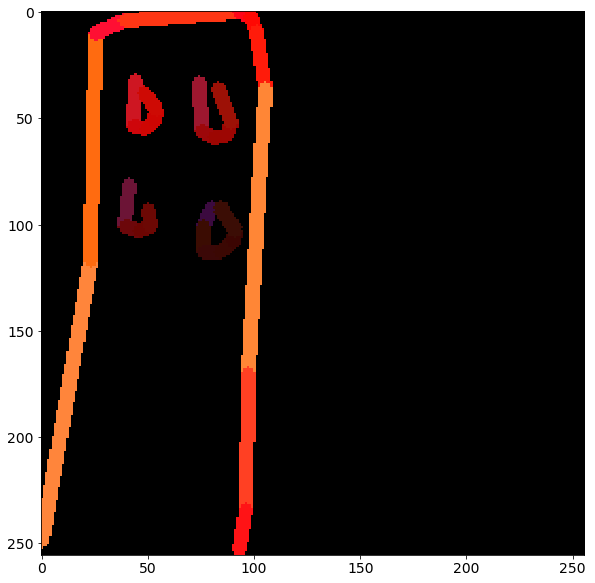

In [98]:
tt_df = pd.read_csv(os.path.join(path_new, 'train_k{}.csv.gz'.format(0)))
tt_df.head()


tt = json.loads(tt_df.drawing.values[17])
aimg = draw_cv2_color_new(tt)
plt.imshow(aimg)#, cmap='gray')
plt.show()

In [39]:
train_datagen = image_generator_train(size=size, batchsize=batchsize, vn=valid_file_num,channels=input_shape[2])
valid_datagen = image_generator_val(size=size, batchsize=batchsize, vn=valid_file_num,channels=input_shape[2])

filename = os.path.join(path_new, 'train_k{}.csv.gz'.format(valid_file_num))
v_df = pd.read_csv(filename)
num_val = v_df.shape[0]
v_df=None
print('Objects deleted',gc.collect())
print(num_val, batchsize)

Objects deleted 106
17134 90


In [40]:

if is_restart == True:
    try:
        model.load_weights(best_save_model_file)
    except:
        print('File not found')

File not found


In [41]:
hists = []
print('batchsize', batchsize, 'save_path', best_save_model_file)

batchsize 90 save_path weights/InceptionResNetV2_is_(139, 139, 3)_bs_90_lf_None_vf_99_use_raw_False.h5


In [42]:
hist = model.fit_generator( train_datagen, steps_per_epoch=STEPS, validation_data=valid_datagen
                           , validation_steps=num_val//batchsize,
                           epochs=EPOCHS, verbose=2,   callbacks = callbacks )
hists.append(hist)

Epoch 1/16


ResourceExhaustedError: OOM when allocating tensor with shape[90,3,3,192] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/zeros_115-0-1-TransposeNCHWToNHWC-LayoutOptimizer}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/zeros_115, PermConstNCHWToNHWC-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node metrics/top_3_accuracy/Mean_1/_10443}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_59405_metrics/top_3_accuracy/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
